## HomeWork 3: Unemployement

To visualize on NbViewer go to : https://nbviewer.jupyter.org/github/Babas10/ADA_JEX2017/blob/master/HomeWork/03%20-%20Interactive%20Viz/HomeWork3Final.ipynb?flush_cache=true?flush_cache=true

Unemployment rates represent unemployed persons as a percentage of the labour force. The labour force is the total number of people employed and unemployed. Unemployed persons comprise persons aged 15 to 74 who were: a. without work during the reference week, b. currently available for work, i.e. were available for paid employment or self-employment before the end of the two weeks following the reference week, c. actively seeking work, i.e. had taken specific steps in the four weeks period ending with the reference week to seek paid employment or self-employment or who found a job to start later, i.e. within a period of, at most, three months.

In [4]:
import os
import pandas as pd
import json
import folium
import branca.colormap as cm
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets,interact
from IPython.display import display

### Europe Unemployement

In [6]:
# Loading the european map
country_geo_path = r'./topojson/europe.topojson.json'
topo_json_data = json.load(open(country_geo_path))

In [7]:
# Loading the unemployement data set and selecting the interesting columns
unemployement_data_file=r'Eurostat_Table_unemployement.xls'
unemployement_data=pd.read_excel(unemployement_data_file,skiprows=3)
unemployement_data_2016=pd.concat([unemployement_data['geo\\time'][0:38], unemployement_data['2016'][0:38]], axis=1)
unemployement_data_2016.rename(columns={'geo\\time': 'Country', '2016': 'UnemployementRate'}, inplace=True)

#delete row with switerland and unvalid value: could be add later if needed

unemployement_data_2016=unemployement_data_2016[unemployement_data_2016['UnemployementRate'] != ':']
unemployement_data_2016=unemployement_data_2016.apply(pd.to_numeric, errors='ignore')
unemployement_data_2016=unemployement_data_2016[4:]
display(unemployement_data_2016.head())

,Country,UnemployementRate
4,Belgium,7.8
5,Bulgaria,7.6
6,Czech Republic,4.0
7,Denmark,6.2
8,Germany,4.1


graph des quantiles: à définir si on garde 
-rajouter legende et autres

## We load directly the data for switzerland as they will be needed in the comparison to europe

In [8]:
canton_geo_path = r'./topojson/ch-cantons.topojson.json'
topo_json_dataSwiss = json.load(open(canton_geo_path))

m_swiss= folium.Map([46.5,8], tiles='cartodbpositron', zoom_start=8)


We noticed that the name of the cantons in the file that we get from the website are with their respective language name. Luckily, in this case we noticed as well that the order of the topo for the cantons is the same as the xlsx file. So we just mapped "linearly" the cantons name in the topoJson with the unemployement rate from the data set.

In [9]:
topocantons = []
for i in range(26):
    topocantons.append(topo_json_dataSwiss['objects']['cantons']['geometries'][i]['properties']['name'])
cantonS = pd.Series(topocantons)

In [10]:
cantonS=cantonS.append(pd.Series(['Total']),ignore_index=True)

We get the data for 2016 to have the same year as for Europe and then we compute the average over the 12 months for the "Chômage" and "Demandeur d'emplois".

As we noticed, the site does not give the actual rate for "Demandeur d'emplois but only the number of people. From the number of people of the "Chômage" and its rate we got the total active population that helps us to get the rate for "Demandeur d'emplois"

In [11]:
unemployement_data_file_suisse=r'Taux_suisse_2016.xlsx'
unemployement_data=pd.read_excel(unemployement_data_file_suisse,skiprows=3)
#display(unemployement_data.head())
unemployement_data_suisse=pd.concat([unemployement_data['Unnamed: 0'], unemployement_data['Taux de chômage.12'],unemployement_data["Chômeurs inscrits.12"],unemployement_data["Demandeurs d'emploi.12"]], axis=1)

unemployement_data_suisse['Canton Names'] = cantonS
unemployement_data_suisse['Demandeurs d\'emploi.12']=unemployement_data_suisse['Demandeurs d\'emploi.12']/12
unemployement_data_suisse['Chômeurs inscrits.12']=unemployement_data_suisse['Chômeurs inscrits.12']/12

unemployement_data_suisse['Population active']=100*unemployement_data_suisse['Chômeurs inscrits.12']/unemployement_data_suisse['Taux de chômage.12']
unemployement_data_suisse["Taux Demandeur d'emplois"]=unemployement_data_suisse['Demandeurs d\'emploi.12']/unemployement_data_suisse['Population active']*100


cols = list(unemployement_data_suisse)
cols.pop(cols.index("Unnamed: 0"))
cols.insert(0, cols.pop(cols.index("Canton Names")))
cols.insert(2, cols.pop(cols.index("Taux Demandeur d'emplois")))
unemployement_data_suisse = unemployement_data_suisse.loc[:, cols]
unemployement_data_suisse.rename(columns={'Taux de chômage.12': 'Taux de chômage', 'Chômeurs inscrits.12': 'Chômeurs inscrits',"Demandeurs d'emploi.12":"Demandeurs d'emploi"}, inplace=True)
display(unemployement_data_suisse.head(5))
chomage_swiss_dict = unemployement_data_suisse.set_index('Canton Names')['Taux de chômage']
demandeur_swiss_dict = unemployement_data_suisse.set_index('Canton Names')["Taux Demandeur d'emplois"]
taux_suisse=unemployement_data_suisse[unemployement_data_suisse['Canton Names']=='Total']['Taux de chômage']


,Canton Names,Taux de chômage,Taux Demandeur d'emplois,Chômeurs inscrits,Demandeurs d'emploi,Population active
0,Zürich,3.7,4.524274,30083.916667,36785.916667,813078.828829
1,Bern/Berne,2.7,3.548183,15283.166667,20084.250000,566043.209877
2,Luzern,2.1,3.407361,4601.750000,7466.583333,219130.952381
3,Uri,1.0,1.803557,201.500000,363.416667,20150.000000
4,Schwyz,1.8,2.681069,1537.166667,2289.583333,85398.148148


## Spliting data set decision

Here we wanted to see which splitting rule we had to choose in order to represent the unemployment in Europe in an optimal way. Our first idea was to use the standard quantiles, i.e. 25%, 50% 75% 100%. With this method we were not satisfied, indeed we would like to have a "threshold" that split our data in groups that have similar unemployment rate. Looking at the first bar plot, we don't really see a difference between the 15th country and the 20th country. Unsatisfied, we decide to create a splitting criterion, which is more related to the health of a country. A country with less than 5% of unemployment is a country in a good shape. Between 5% and 9% is ok, then between 9% and 13% are countries that should care about the situation and improve. More than 13% countries with real problems. Thus we found the quantiles that fit our scale. When looking at the second bar plot, we believe groups are best distributed related to the unemployment. This scale is the one we will use for the map plot.

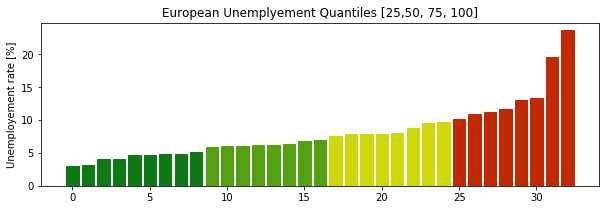

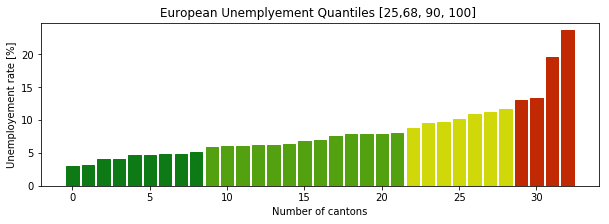

In [12]:
fig = plt.gcf()
fig.set_size_inches(10, 3)

quantiles = np.percentile(unemployement_data_2016['UnemployementRate'],[25,50, 75, 100])
sortedEl = unemployement_data_2016['UnemployementRate'].sort_values()
barlist=plt.bar(np.arange(len(sortedEl)) , sortedEl.iloc[np.arange(len(sortedEl))])
#color = ['#e0ecf4','#9ebcda','#2b8cbe','#8856a7']
color =['#0e7a15','#53a010','#d1d80a','#c12903']


for q,j in enumerate (quantiles):
    
    for i in np.where(sortedEl <= quantiles[3-q])[0]:
        barlist[i].set_color(color[3-q])
plt.ylabel('Unemployement rate [%]')
plt.title('European Unemplyement Quantiles [25,50, 75, 100]')
     
plt.show()


fig = plt.gcf()
fig.set_size_inches(10, 3)

quantiles = np.percentile(unemployement_data_2016['UnemployementRate'],[25,68, 90, 100])
sortedEl = unemployement_data_2016['UnemployementRate'].sort_values()
barlist=plt.bar(np.arange(len(sortedEl)) , sortedEl.iloc[np.arange(len(sortedEl))])
#color = ['#e0ecf4','#9ebcda','#2b8cbe','#8856a7']
color =['#0e7a15','#53a010','#d1d80a','#c12903']
for q,j in enumerate (quantiles):
    
    for i in np.where(sortedEl <= quantiles[3-q])[0]:
        barlist[i].set_color(color[3-q])
plt.ylabel('Unemployement rate [%]')
plt.xlabel('Number of cantons')


plt.title('European Unemplyement Quantiles [25,68, 90, 100] ')
     
plt.show()


#### Function to color map 

The next step was to select a set of colors that express well the health of a country. We decide to use a linear scale going from the color green, which express friendliness to red which expresses danger.

In [13]:
colormap = cm.linear.YlGn.scale(
    unemployement_data_2016['UnemployementRate'].min(),
    unemployement_data_2016['UnemployementRate'].max())

unemployment_dict = unemployement_data_2016.set_index('Country')['UnemployementRate']
unemployment_dict['Switzerland']=taux_suisse.values[0]
linear = cm.LinearColormap(['green','yellow','red'], vmin=3., vmax=10.)

final=linear.to_step(
               data=unemployement_data_2016['UnemployementRate'],
               method='quantiles',
               quantiles=[0, 0.25,0.68, 0.9, 1],
               round_method='int')

we chose color that directly tells us if it's good or bad (green and red)

In [14]:
def mycolor(pays):
    if unemployment_dict.get(pays,0)==0:
        return '#D3D3D3'
    else:
        color=final(unemployment_dict[pays])
        return color

In [15]:
eu_map= folium.Map([48,15], tiles='cartodbpositron', zoom_start=4)
folium.TopoJson(topo_json_data,'objects.europe',
    style_function=lambda feature: {
        'fillColor': mycolor(feature['properties']['NAME']),
        'color': 'black',
        'fillOpacity':0.5,
        'weight': 1,
        'dashArray': '5, 5'}).add_to(eu_map)
final.caption = 'UnemployementRate'
eu_map.add_child(final)
eu_map

### Switzerland

Now we need to choose a good colormap that suits both.
We used a simple linear colormap between green and yellow. The same reason than for the European map, green is a friendly color, that suit well to cantons or countries with a low unemployment rate. Yellow is more an alarming color that fits well to cantons with the highest unemployment rate. We decided to use yellow and not red to be coherent with the European map, indeed in Switzerland there is no cantons with an unemployment rate as high as the majority of the European countries, thus it would not be correct to use the red color for the worst cantons.

The reason why we chose linear colormap is that it does not introduce a biais to compare two maps. When using classes, a rate can move from the max of a class to the min with no change of color and inversely just increase by 0.01 and change class. We found this situation not suitable to compare two maps. 
The downside is that the rate of cantons are harder to distinguish.

In [16]:
max_employement=unemployement_data_suisse["Taux Demandeur d'emplois"].max()
#print(unemployement_data_suisse['Taux de chômage'].min())
linear2 = cm.LinearColormap(['green','yellow'], vmin=0, vmax=max_employement)
def mycolor2(pays):
    if chomage_swiss_dict.get(pays,0)==0:
        return '#D3D3D3'
    else:
        color=linear2(chomage_swiss_dict[pays])
        return color
def mycolor3(pays):
    if demandeur_swiss_dict.get(pays,0)==0:
        return '#D3D3D3'
    else:
        color=linear2(demandeur_swiss_dict[pays])
        return color

## Now we plot the rate of all the people looking for a job in Switzerland


In [17]:
m_swiss= folium.Map([46.5,8], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(topo_json_dataSwiss,'objects.cantons',
    style_function=lambda feature: {
        'fillColor': mycolor3(feature['properties']['name']),
        'color': 'black',
        'fillOpacity':0.6,
        'weight': 1,
        'dashArray': '5, 5'}).add_to(m_swiss)
linear2.caption = 'UnemployementRate'
m_swiss.add_child(linear2)
m_swiss

## For Only Unemployed people with no job we get a much "greener map".

In [18]:
m_swiss= folium.Map([46.5,8], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(topo_json_dataSwiss,'objects.cantons',
    style_function=lambda feature: {
        'fillColor': mycolor2(feature['properties']['name']),
        'color': 'black',
        'fillOpacity':0.6,
        'weight': 1,
        'dashArray': '5, 5'}).add_to(m_swiss)
linear2.caption = 'UnemployementRate (no current job)'
m_swiss.add_child(linear2)
m_swiss

Now we can Redo the maps with a different color mapping. Exemple step color

In [19]:
final2=linear2.to_step(
               method='linear',
               index=[0,3,4,6, max_employement],
                round_method=None)
               #quantiles=[0, 0.33,0.50, 1]) for reustigraben
def mycolor2(pays):
    if chomage_swiss_dict.get(pays,0)==0:
        return '#D3D3D3'
    else:
        color=final2(chomage_swiss_dict[pays])
        return color
def mycolor3(pays):
    if demandeur_swiss_dict.get(pays,0)==0:
        return '#D3D3D3'
    else:
        color=final2(demandeur_swiss_dict[pays])
        return color
    
m_swiss= folium.Map([46.5,8], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(topo_json_dataSwiss,'objects.cantons',
    style_function=lambda feature: {
        'fillColor': mycolor3(feature['properties']['name']),
        'color': 'black',
        'fillOpacity':0.6,
        'weight': 1,
        'dashArray': '5, 5'}).add_to(m_swiss)
final2.caption = 'UnemployementRate'
m_swiss.add_child(final2)
display(m_swiss)
m_swiss= folium.Map([46.5,8], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(topo_json_dataSwiss,'objects.cantons',
    style_function=lambda feature: {
        'fillColor': mycolor2(feature['properties']['name']),
        'color': 'black',
        'fillOpacity':0.6,
        'weight': 1,
        'dashArray': '5, 5'}).add_to(m_swiss)
final2.caption = 'UnemployementRate (no current Job)'
m_swiss.add_child(final2)
m_swiss

With this stepcolor the map expresses more yellow, and the second has a stronger green. With this step we imagine than the two different rates are really far apart. 

## Nationality Unemployement Rate in Switzerland

In [20]:
topocantons = []
abr_dic={}
for i in range(26):
    abr_dic[topo_json_dataSwiss['objects']['cantons']['geometries'][i]['properties']['name']]=topo_json_dataSwiss['objects']['cantons']['geometries'][i]['id']
    topocantons.append(topo_json_dataSwiss['objects']['cantons']['geometries'][i]['properties']['name'])
cantonS = pd.Series(topocantons)

In [21]:
unemployement_data_file_suisseI=r'TauxdechômageNationalitées.xlsx'
unemployement_dataS=pd.read_excel(unemployement_data_file_suisseI,skiprows=3, usecols = [0,1,51])
unemployement_dataS = unemployement_dataS.set_index('Unnamed: 1')

series = {'Canton': cantonS.tolist(), 'Taux de Chômage Suisses': unemployement_dataS.loc[['Suisses'], 'Taux de chômage.12'].tolist(), 'Taux de Chômage Etranger': unemployement_dataS.loc[['Etrangers'], 'Taux de chômage.12'].tolist() }
swissUnemployement =pd.DataFrame(data=series)
swissUnemployement['Diff Taux de Chômage'] = swissUnemployement['Taux de Chômage Etranger'] - swissUnemployement['Taux de Chômage Suisses']
display(swissUnemployement.head(5))

,Canton,Taux de Chômage Etranger,Taux de Chômage Suisses,Diff Taux de Chômage
0,Zürich,6.0,2.8,3.2
1,Bern/Berne,6.5,2.0,4.5
2,Luzern,4.7,1.5,3.2
3,Uri,4.2,0.6,3.6
4,Schwyz,3.9,1.2,2.7


In [22]:
unemployment_Etranger_dict = swissUnemployement.set_index('Canton')['Taux de Chômage Etranger']
unemployment_Swiss_dict = swissUnemployement.set_index('Canton')['Taux de Chômage Suisses']
unemployment_Diff_dict = swissUnemployement.set_index('Canton')['Diff Taux de Chômage']

In [23]:
def mycolor_swiss(pays):
    if unemployment_Swiss_dict.get(pays,0)==0:
        return '#D3D3D3'
    else:
        color=step_color(unemployment_Swiss_dict[pays])
        return color
    
def mycolor_etranger(pays):
    if unemployment_Etranger_dict.get(pays,0)==0:
        return '#D3D3D3'
    else:
        color=step_color(unemployment_Etranger_dict[pays])
        return color

def mycolor_diff(pays):
    if unemployment_Diff_dict.get(pays,0)==0:
        return '#D3D3D3'
    else:
        color=step_color(unemployment_Diff_dict[pays])
        return color

## Swiss unemployed people rate in Switzerland


In [24]:
linear2 = cm.LinearColormap(['green','yellow'], vmin=0, vmax=max_employement)
step_color=linear2.to_step(
               method='linear',
               index=[0,3,7, swissUnemployement['Taux de Chômage Etranger'].max()],
                round_method=None)

In [25]:
m_swiss= folium.Map([46.5,8], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(topo_json_dataSwiss,'objects.cantons',
    style_function=lambda feature: {
        'fillColor': mycolor_swiss(feature['properties']['name']),
        'color': 'black',
        'fillOpacity':0.5,
        'weight': 1,
        'dashArray': '5, 5'}).add_to(m_swiss)
step_color.caption = 'Swiss Unemployment Rate'
m_swiss.add_child(step_color)
display(m_swiss)

## Foreign unemployed people rate in Switzerland

In [26]:
m_swiss= folium.Map([46.5,8], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(topo_json_dataSwiss,'objects.cantons',
    style_function=lambda feature: {
        'fillColor': mycolor_etranger(feature['properties']['name']),
        'color': 'black',
        'fillOpacity':0.5,
        'weight': 1,
        'dashArray': '5, 5'}).add_to(m_swiss)
step_color.caption = 'Foreign Unemployment Rate'
m_swiss.add_child(step_color)
m_swiss

### Analysis:

When looking at both maps, we can see that there is a clear difference between the rate of unemployement whithin swiss and foreign people. Indeed in the first swiss map which represents the swiss people unemployement rate, the colors are almost dark green and a little bit of light green in the french part, while in the second map representing the foreign people unemployement rate, the colors are almost light green and in some part they are yellow. To go further in the analysis we decide to make a map representing the difference of the swiss and foreign people unemployement rate. With this, we will be able to directly see and quantify the difference between swiss and foreign within each canton.

In [27]:
m_swiss= folium.Map([46.5,8], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(topo_json_dataSwiss,'objects.cantons',
    style_function=lambda feature: {
        'fillColor': mycolor_diff(feature['properties']['name']),
        'color': 'black',
        'fillOpacity':0.5,
        'weight': 1,
        'dashArray': '5, 5'}).add_to(m_swiss)
step_color.caption = 'Unemployment Rate'
m_swiss.add_child(step_color)
m_swiss

The results of this map are very interesting, we see that in a general way foreign people have an unemployment rate which is above 3% to 5% than the swiss people unemployment. The second interesting point is that the difference of unemployment between the oldest cantons of Switzerland is very low. This could be due to the fact that there are very low number of foreign people in those countries as they are not very welcome, and the ones that are in the canton have a job. Finally, we see that the canton of Jura has a huge difference of unemployement. Finally, we see that the canton of Jura has a huge difference of unemployment. Unfortunately, we don't reach to find an interpretation of it.

## Difference between age groups and nationality

Now we want to refine the analysis by adding the differences between age groups however it was impossible to get the percentage of unemployment with 2 criteria but only numbers. Therefore, we decided to compute approximately the percentage by dividing the number by the population active in each age groups. 

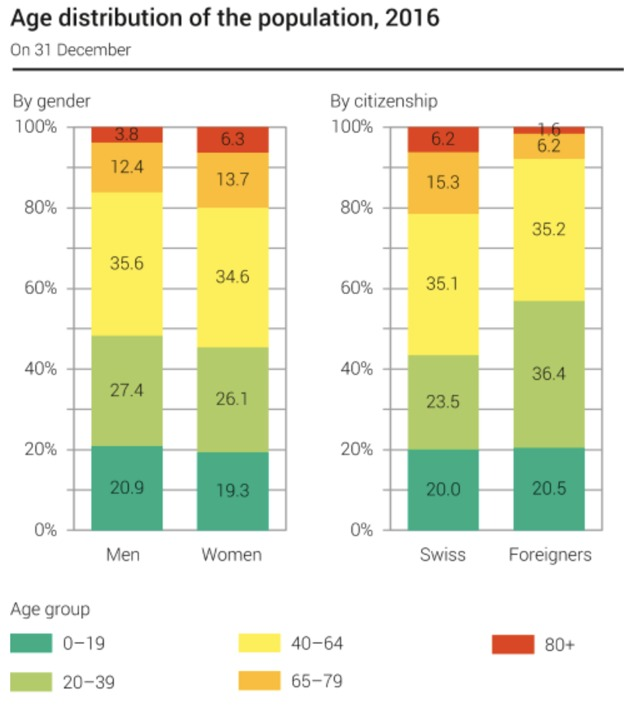

In [28]:
from IPython.display import Image
Image("Age_groups.jpeg",width=300)

Using the bar plot by citizenship, we have approximately the percentage for each group ages. Since the groups' intervals are not the same as used in the dataset we use, we apply a linear approximation to compute approximatively the percentage for our age groups.
We used 3 assumptions :
1. Linear approximations to compute for our groups
2. Make the assumptions that this percentage can be applied to the population active instead of population total. 
3. The percentage is the same for each canton.

In [29]:
# Computing percentage of population for each age category
swiss_percentage15_24 = 20/19*5 + 23.5/19*5
swiss_percentage25_49 = 23.5/19*15 + 35.1/24*9
swiss_percentage50_ = 35.1/24*15 + 15.3

foreigner_percentage15_24 = 20.5/19*5 + 36.4/19*5
foreigner_percentage25_49 = 36.4/19*15 + 35.2/24*9
foreigner_percentage50_ = 35.2/24*15 + 6.2

In [30]:
Population_active=r'TauxdechômageNationalitées.xlsx'
Population_active=pd.read_excel(Population_active,skiprows=3, usecols = [0,1,55])
Population_active = Population_active.set_index('Unnamed: 1')
series = {'Canton': cantonS.tolist(), 'Population active Suisses': Population_active.loc[['Suisses'], 'Unnamed: 55'].tolist(), 'Population active Etranger': Population_active.loc[['Etrangers'], 'Unnamed: 55'].tolist() }
swiss =pd.DataFrame(data=series)

In [31]:
# Compute the population active for each age category and in each canton
swiss_per_15_24 = swiss['Population active Suisses'].values*(swiss_percentage15_24/100)
swiss_per_25_49 = swiss['Population active Suisses'].values*(swiss_percentage25_49/100)
swiss_per_50_ = swiss['Population active Suisses'].values*(swiss_percentage50_/100)

foreigner_per_15_24 = swiss['Population active Etranger'].values*(foreigner_percentage15_24/100)
foreigner_per_25_49 = swiss['Population active Etranger'].values*((foreigner_percentage25_49-10)/100)
foreigner_per_50_ = swiss['Population active Etranger'].values*(foreigner_percentage50_/100)

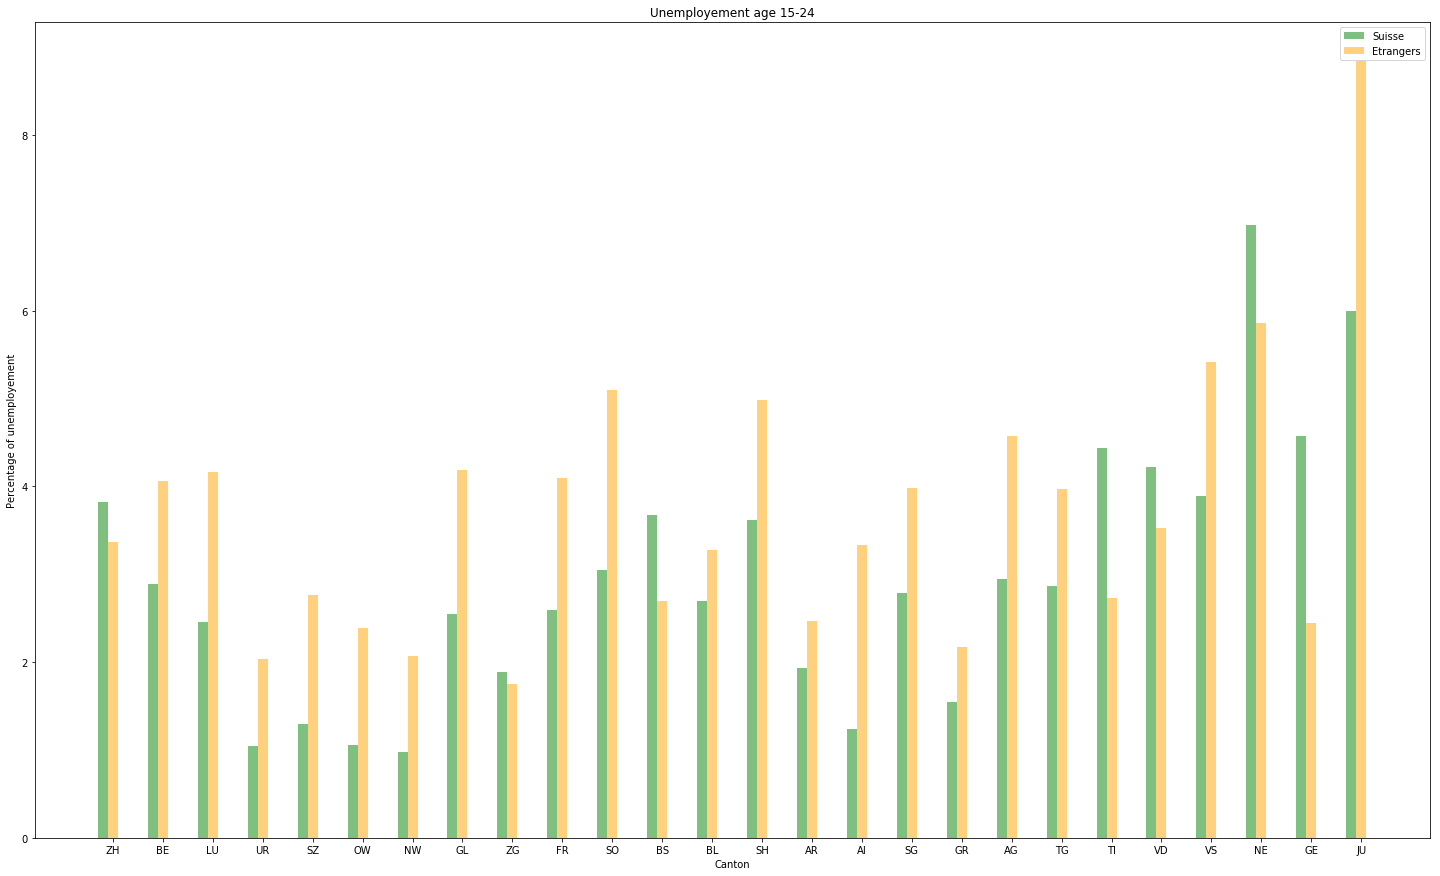

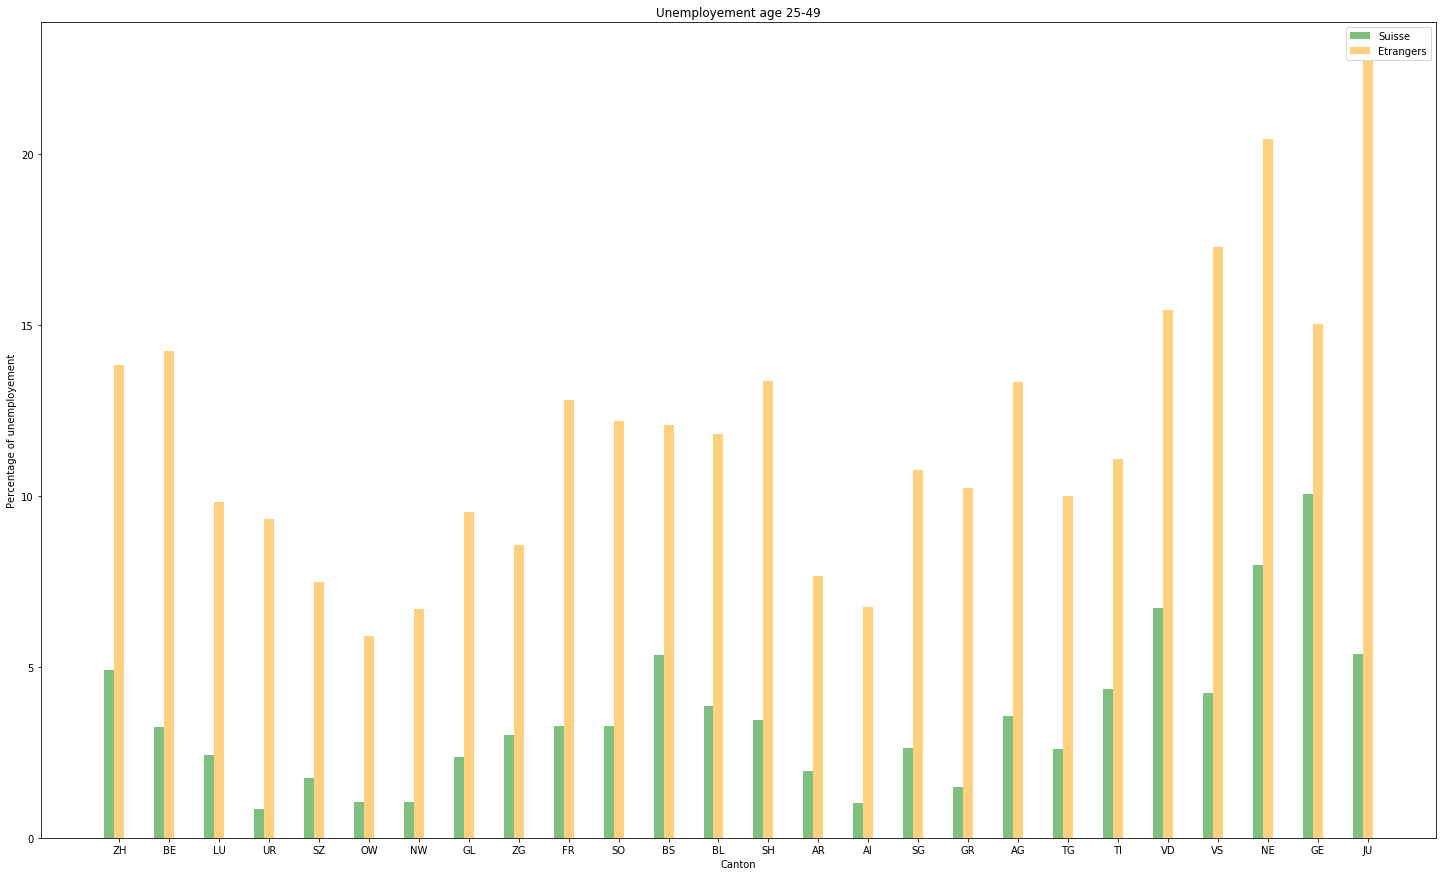

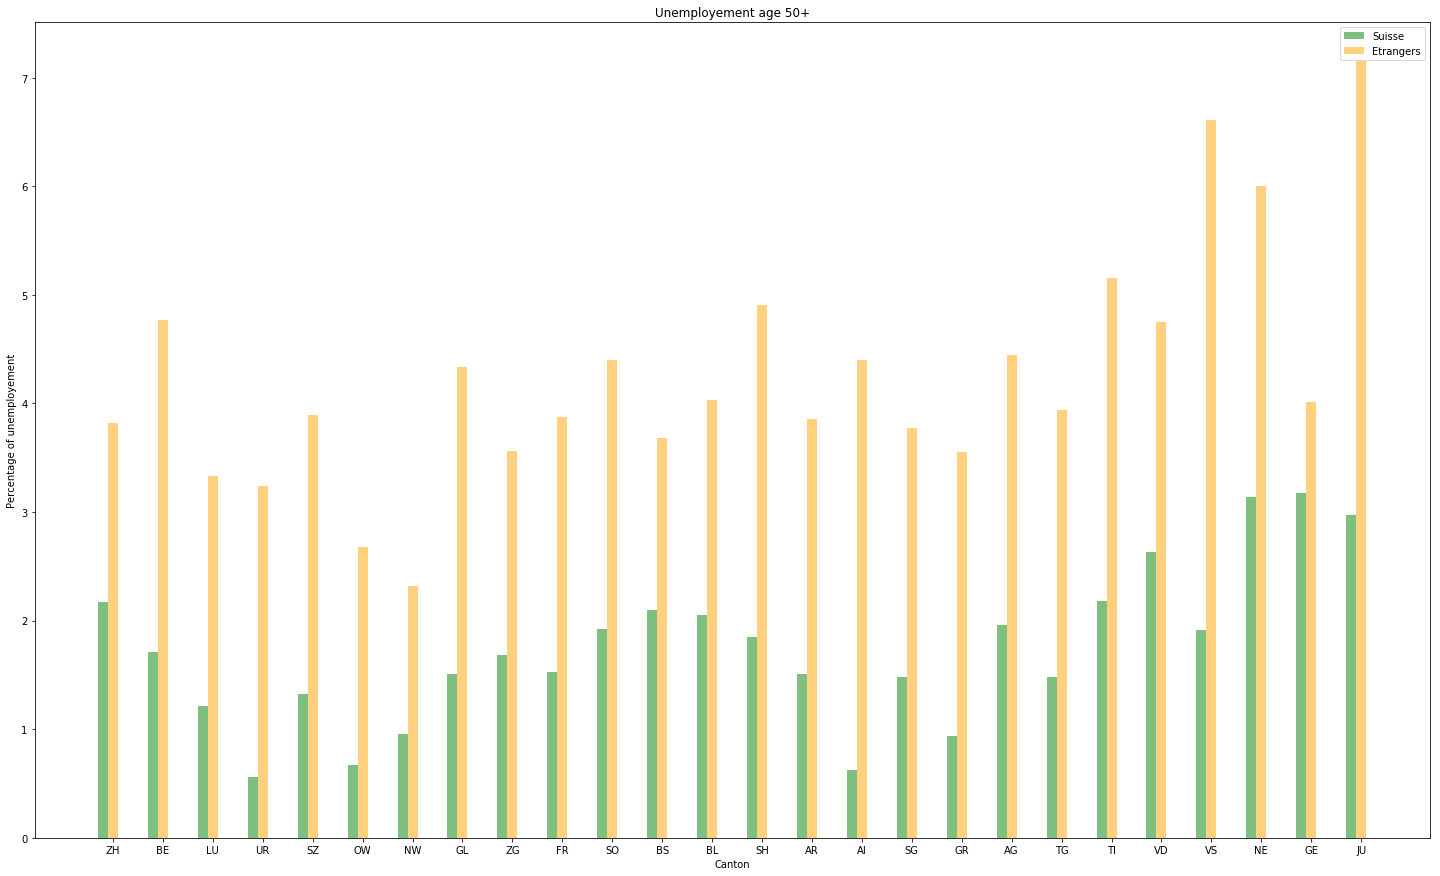

In [32]:
unemployement_data_file_suisse_age=r'Chomeurs_ages_2016.xlsx' # Extract the data from the dataset
unemployement_data_age=pd.read_excel(unemployement_data_file_suisse_age,skiprows=3, usecols = [0,1,2,17])
unemployement_data_age = unemployement_data_age.set_index('Unnamed: 1')

# Taking the mean over the year of number of unemployed in each canton and for each age category
swiss_15_24 = unemployement_data_age.loc[['Suisses'], 'Moyenne'][0::4].tolist()
swiss_25_49 = unemployement_data_age.loc[['Suisses'], 'Moyenne'][1::4].tolist()
swiss_50_inf = unemployement_data_age.loc[['Suisses'], 'Moyenne'][2::4].tolist()

foreign_15_24 =unemployement_data_age.loc[['Etrangers'], 'Moyenne'][0::4].tolist()
foreign_25_49 = unemployement_data_age.loc[['Etrangers'], 'Moyenne'][1::4].tolist()
foreign_50_inf =unemployement_data_age.loc[['Etrangers'], 'Moyenne'][2::4].tolist()


# Plot for age between 15 and 24 years old
fig = plt.gcf()
fig.set_size_inches(25, 15)

travel = (abr_dic).values()
bar_width = 0.2
x = np.arange(len(swiss_15_24))
opacity = 0.5
plt.bar(x,swiss_15_24/swiss_per_15_24*100,bar_width, color ='green', label = 'Suisse', alpha = opacity)
plt.bar(x + bar_width ,foreign_15_24/foreigner_per_15_24*100,bar_width, color ='orange', label = 'Etrangers', alpha = opacity)
plt.legend()
plt.xlabel('Canton')
plt.ylabel('Percentage of unemployement')
plt.title('Unemployement age 15-24')
plt.xticks(x +bar_width, travel)

plt.show()

# Plot for age between 25 and 49 years old
fig = plt.gcf()
fig.set_size_inches(25, 15)

bar_width = 0.2
x = np.arange(len(swiss_15_24))
opacity = 0.5
plt.bar(x,swiss_25_49/swiss_per_25_49*100,bar_width, color ='green', label = 'Suisse', alpha = opacity)
plt.bar(x + bar_width ,foreign_25_49/foreigner_per_25_49*100 ,bar_width, color ='orange', label = 'Etrangers', alpha = opacity)
plt.legend()
plt.xlabel('Canton')
plt.ylabel('Percentage of unemployement')
plt.title('Unemployement age 25-49')
plt.xticks(x +bar_width, travel)

plt.show()

# Plot for age over 50
fig = plt.gcf()
fig.set_size_inches(25, 15)

bar_width = 0.2
x = np.arange(len(swiss_15_24))
opacity = 0.5
plt.bar(x,swiss_50_inf/swiss_per_50_*100,bar_width, color ='green', label = 'Suisse', alpha = opacity)
plt.bar(x + bar_width ,foreign_50_inf/foreigner_per_50_*100,bar_width, color ='orange', label = 'Etrangers', alpha = opacity)
plt.legend()
plt.xlabel('Canton')
plt.ylabel('Percentage of unemployement')
plt.title('Unemployement age 50+')
plt.xticks(x +bar_width, travel)

plt.show()

Now that we have approximately the percentage of unemployement for different age groups in each canton. We can compare the difference between Swiss and Foreigners for each category. We can notice that between 15-24 the difference is less marked than for the other categories. Moreover, we can notice that the jura has the highest rate of unemployed for foreigners among all cantons.